In [1]:
#Install recquired libraries
#!pip install prophet
from prophet import Prophet

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from scipy.optimize import linprog
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Load data
file_path = "FP_BA_Netflix - copia (2)/cleaned_merged_data.csv" 
data = pd.read_csv(file_path)

# Create an 'impact' column
# Calculate impact as rating * votes to quantify content popularity and quality
data['impact'] = data['rating'] * data['votes']

# Optimization

In [8]:
# Select content based on impact and total duration limit
# Define the cost vector (negative impact because linprog minimizes by default)
c = -data['impact']

# Constraint: total maximum duration (e.g., 50,000 minutes)
max_duration = 50000  # You can adjust this value as needed
A = [data['duration_min']]
b = [max_duration]



In [10]:
# Bounds for each variable (binary: 0 or 1, indicating whether the content is selected)
bounds = [(0, 1) for _ in range(len(data))]

# Solve the optimization problem
result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')

# Mark selected content in the dataset
data['selected'] = result.x.round()

# Filter the selected content for further analysis
selected_content = data[data['selected'] == 1]

In [11]:
# Display the selected content in a standard Jupyter Notebook
from IPython.display import display
display(selected_content)

,title,year,certificate,duration_min,genre,rating,description,stars,votes,warnings,language,type,production_countries,seasons,impact,selected
0,Breaking Bad,2008,TV-MA,48.0,"Drama, Comedy, Crime, Thriller",9.2,"When walter white, a new mexico chemistry teac...",Unknown,1936461.0,Unknown,Unknown,Show,US,5.0,17815441.2,1.0
1,Stranger Things,2016,TV-14,61.0,"Drama, Scifi, Thriller, Fantasy, Horror",8.6,"When a young boy vanishes, a small town uncove...",Unknown,1220079.0,Unknown,Unknown,Show,US,5.0,10492679.4,1.0
2,The Walking Dead,2010,TV-MA,46.0,"Action, Drama, Horror, Thriller",8.1,Sheriff's deputy rick grimes awakens from a co...,Unknown,1013253.0,Unknown,Unknown,Show,US,11.0,8207349.3,1.0
3,Peaky Blinders,2013,TV-MA,58.0,"Drama, Crime, European",8.7,"A gangster family epic set in 1919 birmingham,...",Unknown,567949.0,Unknown,Unknown,Show,GB,6.0,4941156.3,1.0
4,Black Mirror,2011,TV-MA,59.0,"Scifi, Drama, Thriller, European",8.6,A contemporary british re-working of the twili...,Unknown,560631.0,Unknown,Unknown,Show,GB,5.0,4821426.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11911,Blank Check,1994,UNKNOWN,0.0,Unknown,9.3,Unknown,Unknown,80.0,Parental Guidance Suggested. May Not Be Suitab...,Unknown,Unknown,UNKNOWN,0.0,744.0,1.0
11912,Heavyweights,1995,UNKNOWN,0.0,Unknown,7.4,Unknown,Unknown,80.0,Some Rude Language And Pranks,Unknown,Unknown,UNKNOWN,0.0,592.0,1.0
11913,D2: The Mighty Ducks,1994,UNKNOWN,0.0,Unknown,7.0,Unknown,Unknown,80.0,Some Mild Language And Rough Hockey Action,Unknown,Unknown,UNKNOWN,0.0,560.0,1.0
11914,"Honey, I Shrunk The Kids",1989,UNKNOWN,0.0,Unknown,8.0,Unknown,Unknown,80.0,Parental Guidance Suggested. May Not Be Suitab...,Unknown,Unknown,UNKNOWN,0.0,640.0,1.0


# Decision Analysis

## Decision Tree

In [16]:
# Select features for the decision tree
features = ['rating', 'votes', 'duration_min', 'type']  # Relevant features
target = 'selected'  # Target variable: selected (1 if chosen by the optimization)

# Encode categorical variables
data['type'] = data['type'].astype('category').cat.codes

# Define feature matrix (X) and target variable (y)
X = data[features]
y = data[target]

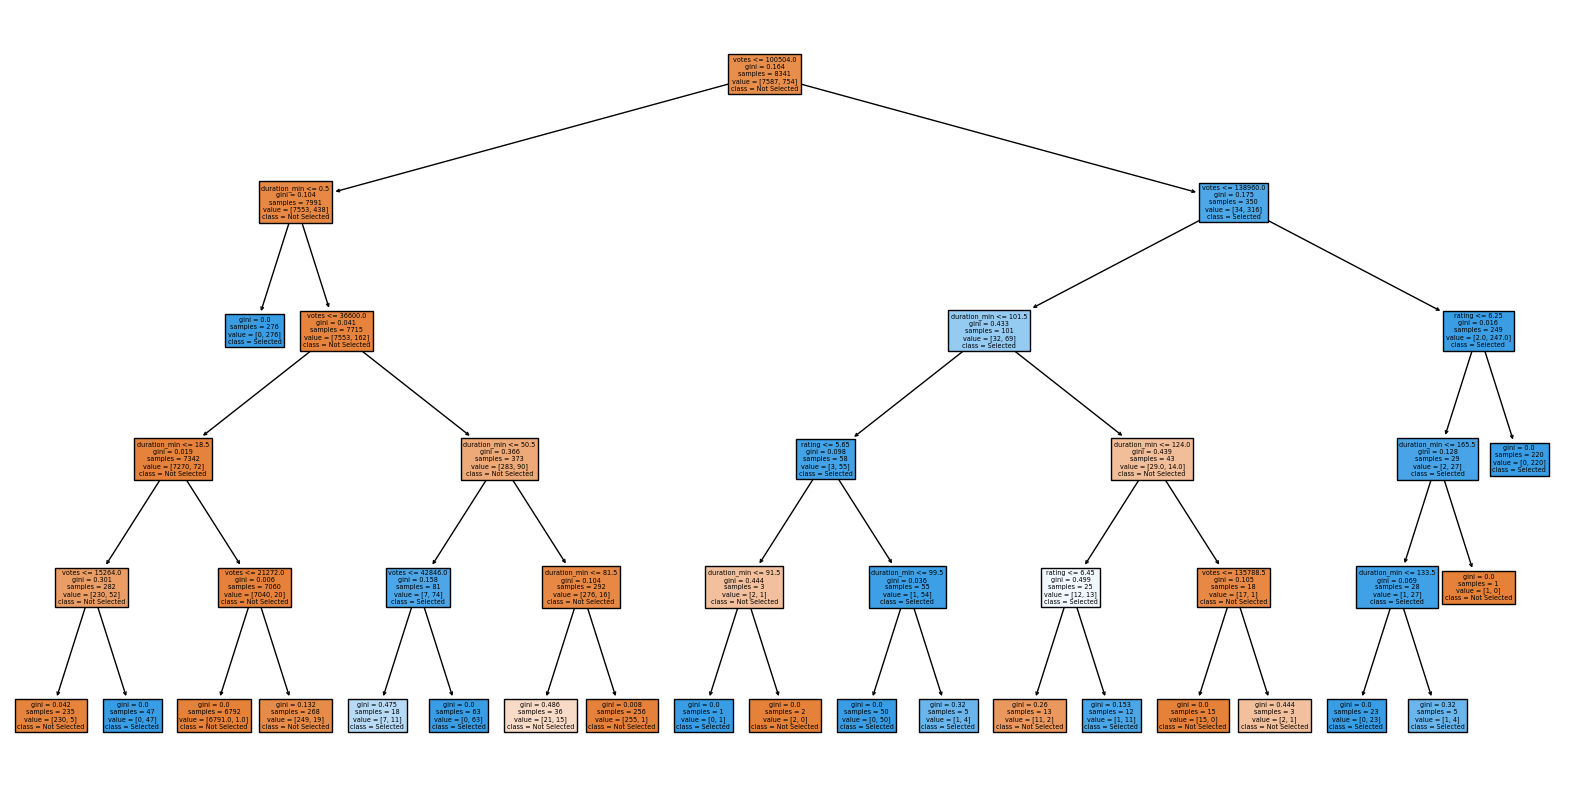

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=['Not Selected', 'Selected'], filled=True)
plt.show()

In [20]:
# Export the decision tree rules as text for better understanding
tree_rules = export_text(clf, feature_names=features)
print(tree_rules)

|--- votes <= 100504.00
|   |--- duration_min <= 0.50
|   |   |--- class: 1.0
|   |--- duration_min >  0.50
|   |   |--- votes <= 36600.00
|   |   |   |--- duration_min <= 18.50
|   |   |   |   |--- votes <= 15264.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- votes >  15264.00
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- duration_min >  18.50
|   |   |   |   |--- votes <= 21272.00
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- votes >  21272.00
|   |   |   |   |   |--- class: 0.0
|   |   |--- votes >  36600.00
|   |   |   |--- duration_min <= 50.50
|   |   |   |   |--- votes <= 42846.00
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- votes >  42846.00
|   |   |   |   |   |--- class: 1.0
|   |   |   |--- duration_min >  50.50
|   |   |   |   |--- duration_min <= 81.50
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- duration_min >  81.50
|   |   |   |   |   |--- class: 0.0
|--- votes >  100504.00
|   |--- votes <= 138960.00
|   |   |--- d

## Sensitivity Analysis

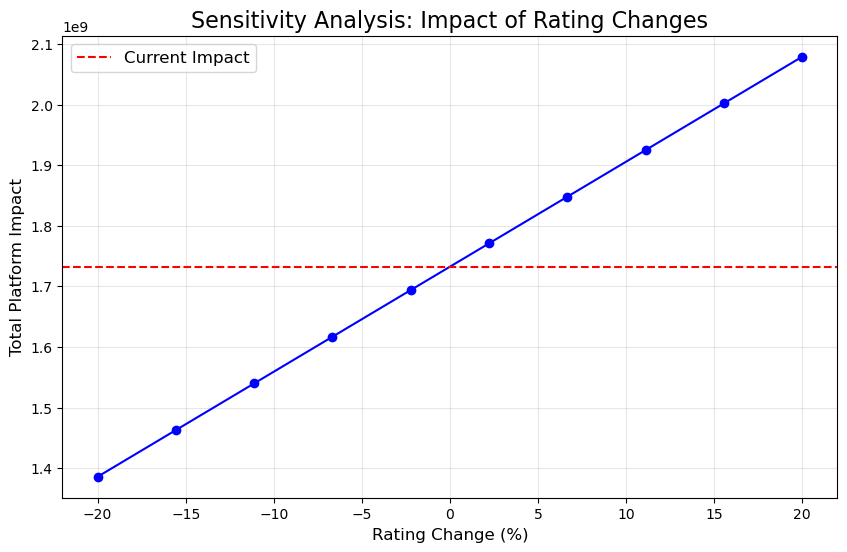

   Rating Change (%)  Total Impact
0         -20.000000  1.385897e+09
1         -15.555556  1.462891e+09
2         -11.111111  1.539885e+09
3          -6.666667  1.616879e+09
4          -2.222222  1.693874e+09
5           2.222222  1.770868e+09
6           6.666667  1.847862e+09
7          11.111111  1.924857e+09
8          15.555556  2.001851e+09
9          20.000000  2.078845e+09


In [23]:
# Ensure the 'impact' column exists
if 'impact' not in data.columns:
    data['impact'] = data['rating'] * data['votes']

# 1. Set up the simulated changes in 'rating'
rating_changes = np.linspace(-0.2, 0.2, 10)  # Changes from -20% to +20% in 'rating'
impact_changes = []  # Store total impact results here

# 2. Simulate changes in 'rating' and calculate total impact
for change in rating_changes:
    simulated_ratings = data['rating'] * (1 + change)  # Apply percentage change
    simulated_impact = simulated_ratings * data['votes']  # Recalculate impact
    impact_changes.append(simulated_impact.sum())  # Save total impact

# 3. Visualize the sensitivity analysis
plt.figure(figsize=(10, 6))
plt.plot(rating_changes * 100, impact_changes, marker='o', linestyle='-', color='blue')
plt.axhline(data['impact'].sum(), color='red', linestyle='--', label='Current Impact')
plt.title("Sensitivity Analysis: Impact of Rating Changes", fontsize=16)
plt.xlabel("Rating Change (%)", fontsize=12)
plt.ylabel("Total Platform Impact", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# 4. Summarize results
sensitivity_results = pd.DataFrame({
    'Rating Change (%)': rating_changes * 100,
    'Total Impact': impact_changes
})
print(sensitivity_results)

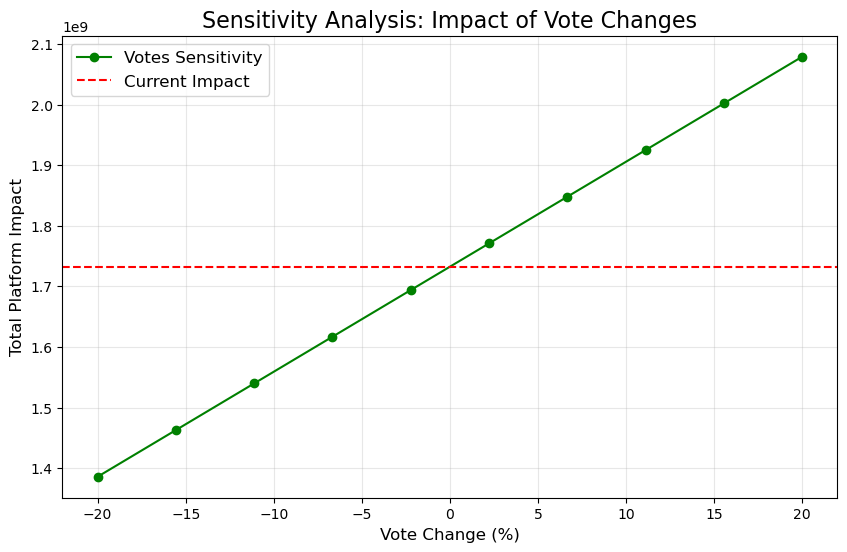

In [25]:
# Simulate changes in 'votes' and calculate total impact
vote_changes = np.linspace(-0.2, 0.2, 10)  # Changes from -20% to +20%
impact_changes_votes = []

for change in vote_changes:
    simulated_votes = data['votes'] * (1 + change)  # Apply percentage change
    simulated_impact_votes = simulated_votes * data['rating']  # Recalculate impact
    impact_changes_votes.append(simulated_impact_votes.sum())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(vote_changes * 100, impact_changes_votes, marker='o', linestyle='-', color='green', label='Votes Sensitivity')
plt.axhline(data['impact'].sum(), color='red', linestyle='--', label='Current Impact')
plt.title("Sensitivity Analysis: Impact of Vote Changes", fontsize=16)
plt.xlabel("Vote Change (%)", fontsize=12)
plt.ylabel("Total Platform Impact", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


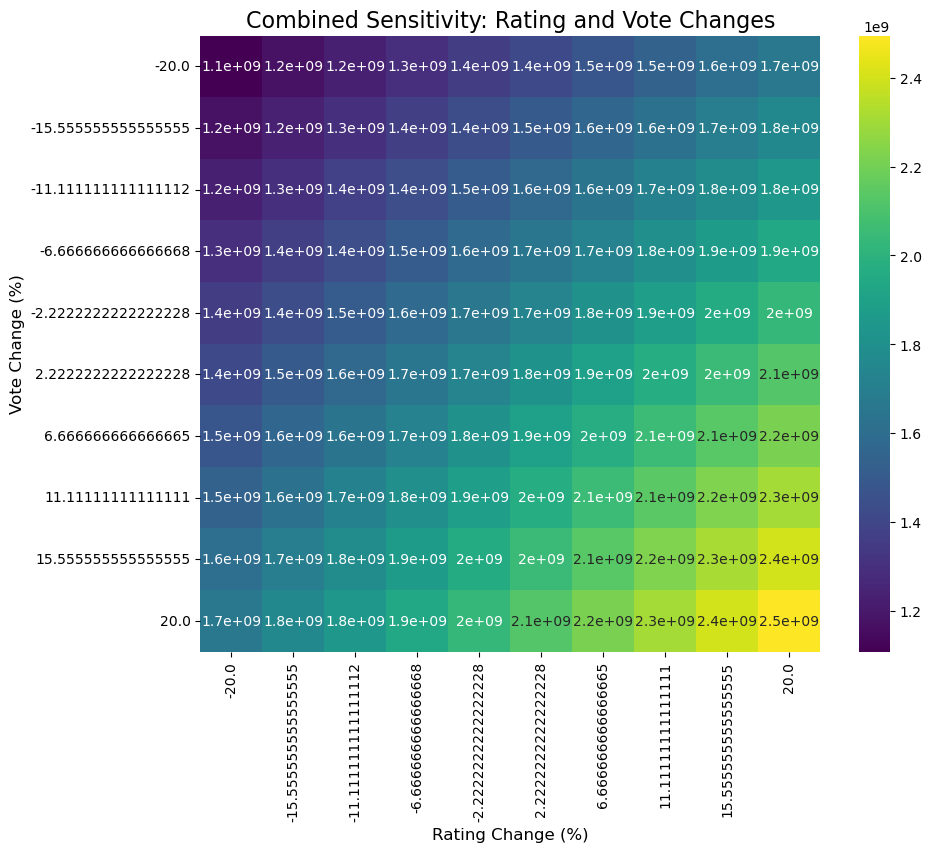

In [27]:
# Create a grid of changes for rating and votes
rating_grid, vote_grid = np.meshgrid(rating_changes, vote_changes)
combined_impact = []

for r_change, v_change in zip(rating_grid.flatten(), vote_grid.flatten()):
    simulated_ratings = data['rating'] * (1 + r_change)
    simulated_votes = data['votes'] * (1 + v_change)
    combined_impact.append((simulated_ratings * simulated_votes).sum())

combined_impact = np.array(combined_impact).reshape(rating_grid.shape)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_impact, xticklabels=rating_changes * 100, yticklabels=vote_changes * 100, cmap='viridis', annot=True)
plt.title("Combined Sensitivity: Rating and Vote Changes", fontsize=16)
plt.xlabel("Rating Change (%)", fontsize=12)
plt.ylabel("Vote Change (%)", fontsize=12)
plt.show()


# Simulation

## Monte Carlo Simulation

In [31]:
# Define the number of simulations
n_simulations = 10000

# Define uncertainty in ratings and votes
# Assume ratings follow a normal distribution (mean and std from dataset)
rating_mean = data['rating'].mean()
rating_std = data['rating'].std()

# Assume votes follow a Poisson distribution (mean from dataset)
votes_mean = data['votes'].mean()

# Generate random simulations for ratings and votes
simulated_ratings = np.random.normal(rating_mean, rating_std, (n_simulations, len(data)))
simulated_votes = np.random.poisson(votes_mean, (n_simulations, len(data)))


In [32]:
#  Calculate simulated impact for each scenario
simulated_impacts = simulated_ratings * simulated_votes

#  Evaluate stability of selected content under simulated scenarios
# (Calculate how often each content would still be selected)
threshold = np.percentile(simulated_impacts, 95, axis=0)  # High-impact threshold
content_stability = (simulated_impacts > threshold).mean(axis=0)

# Add stability results to the dataset
data['stability_score'] = content_stability

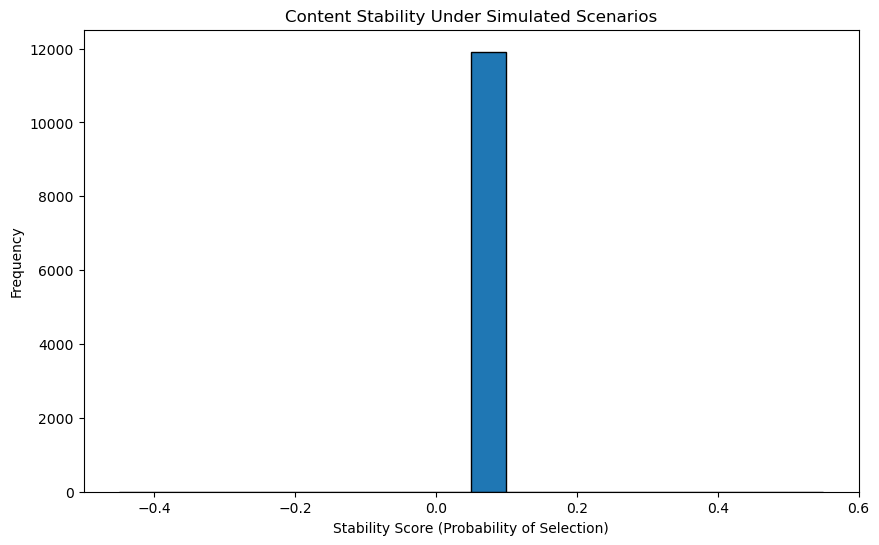

,title,year,certificate,duration_min,genre,rating,description,stars,votes,warnings,language,type,production_countries,seasons,impact,selected,stability_score
0,Breaking Bad,2008,TV-MA,48.0,"Drama, Comedy, Crime, Thriller",9.2,"When walter white, a new mexico chemistry teac...",Unknown,1936461.0,Unknown,Unknown,1,US,5.0,17815441.2,1.0,0.05
1,Stranger Things,2016,TV-14,61.0,"Drama, Scifi, Thriller, Fantasy, Horror",8.6,"When a young boy vanishes, a small town uncove...",Unknown,1220079.0,Unknown,Unknown,1,US,5.0,10492679.4,1.0,0.05
2,The Walking Dead,2010,TV-MA,46.0,"Action, Drama, Horror, Thriller",8.1,Sheriff's deputy rick grimes awakens from a co...,Unknown,1013253.0,Unknown,Unknown,1,US,11.0,8207349.3,1.0,0.05
3,Peaky Blinders,2013,TV-MA,58.0,"Drama, Crime, European",8.7,"A gangster family epic set in 1919 birmingham,...",Unknown,567949.0,Unknown,Unknown,1,GB,6.0,4941156.3,1.0,0.05
4,Black Mirror,2011,TV-MA,59.0,"Scifi, Drama, Thriller, European",8.6,A contemporary british re-working of the twili...,Unknown,560631.0,Unknown,Unknown,1,GB,5.0,4821426.6,1.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11911,Blank Check,1994,UNKNOWN,0.0,Unknown,9.3,Unknown,Unknown,80.0,Parental Guidance Suggested. May Not Be Suitab...,Unknown,2,UNKNOWN,0.0,744.0,1.0,0.05
11912,Heavyweights,1995,UNKNOWN,0.0,Unknown,7.4,Unknown,Unknown,80.0,Some Rude Language And Pranks,Unknown,2,UNKNOWN,0.0,592.0,1.0,0.05
11913,D2: The Mighty Ducks,1994,UNKNOWN,0.0,Unknown,7.0,Unknown,Unknown,80.0,Some Mild Language And Rough Hockey Action,Unknown,2,UNKNOWN,0.0,560.0,1.0,0.05
11914,"Honey, I Shrunk The Kids",1989,UNKNOWN,0.0,Unknown,8.0,Unknown,Unknown,80.0,Parental Guidance Suggested. May Not Be Suitab...,Unknown,2,UNKNOWN,0.0,640.0,1.0,0.05


In [33]:
# Visualize simulation results
# Stability distribution
plt.figure(figsize=(10, 6))
plt.hist(data['stability_score'], bins=20, edgecolor='black')
plt.title("Content Stability Under Simulated Scenarios")
plt.xlabel("Stability Score (Probability of Selection)")
plt.ylabel("Frequency")
plt.show()

# Highlight high-risk content (low stability)
high_risk_content = data[data['stability_score'] < 0.5]

# Display the high-risk content for review
from IPython.display import display
display(high_risk_content)

In [34]:
# Summary analysis
print(f"Number of high-risk content items: {len(high_risk_content)}")
print("These items have a low probability of being selected under simulated scenarios.")

Number of high-risk content items: 11916
These items have a low probability of being selected under simulated scenarios.


## Markov Chain Simulation

In [36]:
# Define states based on content impact
# Divide impact into discrete states: "low", "medium", "high"
bins = [0, data['impact'].quantile(0.33), data['impact'].quantile(0.66), data['impact'].max()]
labels = ['low', 'medium', 'high']
data['popularity_state'] = pd.cut(data['impact'], bins=bins, labels=labels)

In [37]:
# Create a transition matrix
# Count transitions between states based on historical data
transition_counts = pd.crosstab(
    data['popularity_state'].shift(-1),  # State at time t+1
    data['popularity_state'],           # State at time t
    normalize='columns'
)

# Ensure no NaNs in the transition matrix
transition_matrix = transition_counts.fillna(0).values

# Display the transition matrix
print("Transition Matrix:")
print(transition_matrix)

Transition Matrix:
[[9.55794504e-01 3.76398779e-02 0.00000000e+00]
 [4.33094385e-02 9.32858596e-01 2.93754628e-02]
 [8.96057348e-04 2.95015259e-02 9.70624537e-01]]


In [38]:
# Initialize a Markov Chain simulation
n_steps = 10  # Simulate over 10 time periods
n_states = len(labels)
state_distribution = np.zeros((n_steps, n_states))

# Start with the initial distribution of states
initial_distribution = data['popularity_state'].value_counts(normalize=True).reindex(labels, fill_value=0).values
state_distribution[0] = initial_distribution

# Simulate state distributions over time
for t in range(1, n_steps):
    state_distribution[t] = state_distribution[t - 1] @ transition_matrix

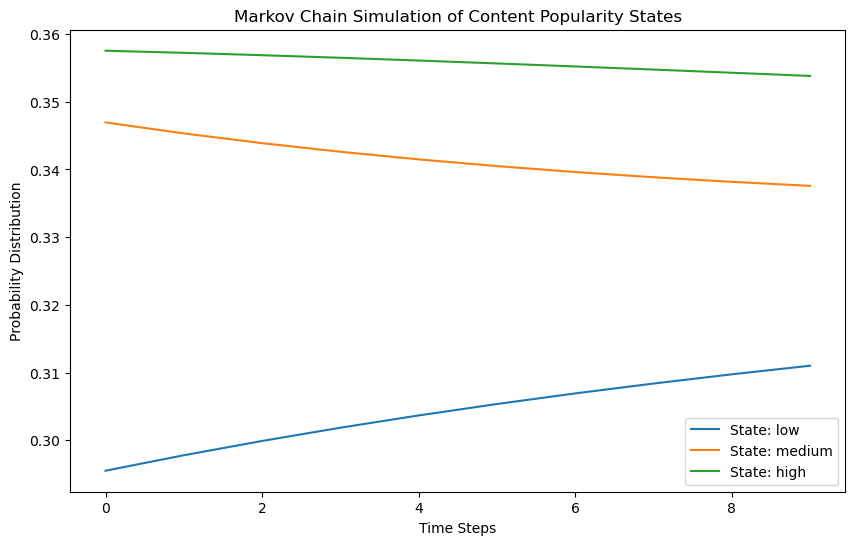

In [39]:
# Visualize the simulation results
plt.figure(figsize=(10, 6))
for i, label in enumerate(labels):
    plt.plot(range(n_steps), state_distribution[:, i], label=f"State: {label}")

plt.title("Markov Chain Simulation of Content Popularity States")
plt.xlabel("Time Steps")
plt.ylabel("Probability Distribution")
plt.legend()
plt.show()


In [40]:
#  Analyze long-term distribution (steady state)
steady_state = np.linalg.matrix_power(transition_matrix, 100)[0]  # Converge to steady state
state_to_prob = dict(zip(labels, steady_state))
print("Steady State Distribution of Popularity States:")
print(dict(zip(labels, steady_state)))



Steady State Distribution of Popularity States:
{'low': 0.30692617003183387, 'medium': 0.2979891197566726, 'high': 0.2835640493335433}


In [41]:
# Assign steady state probabilities to each content item based on impact ranges
data['steady_state_prob'] = data['impact'].apply(
    lambda x: state_to_prob['low'] if x < bins[1] else
              (state_to_prob['medium'] if x < bins[2] else state_to_prob['high'])
)

# Identify content likely to stay in 'low' or 'high' states
low_risk_content = data[data['steady_state_prob'] > 0.5]
high_risk_content = data[data['steady_state_prob'] < 0.2]

# Display high-risk content for review
from IPython.display import display
display(high_risk_content)

# Summary
print(f"Number of high-risk content items: {len(high_risk_content)}")

,title,year,certificate,duration_min,genre,rating,description,stars,votes,warnings,language,type,production_countries,seasons,impact,selected,stability_score,popularity_state,steady_state_prob


Number of high-risk content items: 0


## Time series forecasting

In [43]:
# Prepare time series data
time_series_data = data.groupby('year')['impact'].sum().reset_index()
time_series_data.columns = ['ds', 'y']

#  Ensure 'ds' is a valid datetime format
time_series_data['ds'] = pd.to_datetime(time_series_data['ds'], format='%Y', errors='coerce')

# Handle invalid dates (replace or drop)
if time_series_data['ds'].isnull().any():
    print("Invalid dates found, replacing with default values.")
    time_series_data['ds'] = time_series_data['ds'].fillna(
        pd.to_datetime('1900-01-01')  # Replace with default or drop
    )

Invalid dates found, replacing with default values.


In [44]:
# Initialize and train the Prophet model
model = Prophet()
model.fit(time_series_data)

# Forecast future values
future = model.make_future_dataframe(periods=5, freq='Y')  # Forecast next 5 years
forecast = model.predict(future)

01:31:52 - cmdstanpy - INFO - Chain [1] start processing
01:31:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\mthig\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


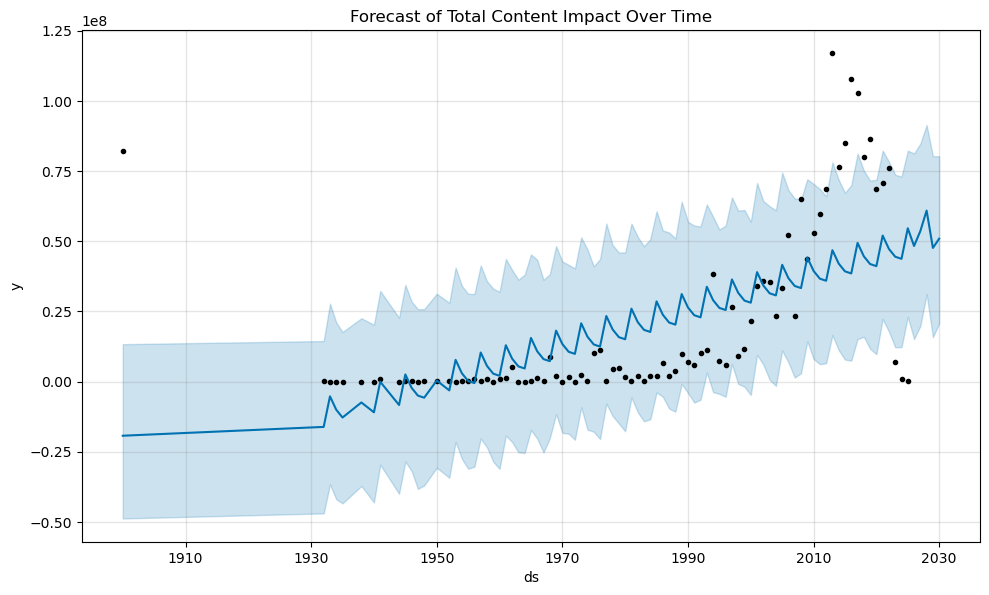

,ds,yhat,yhat_lower,yhat_upper
0,1900-01-01,-1.927584e+07,-4.875227e+07,1.333415e+07
1,1932-01-01,-1.613556e+07,-4.695102e+07,1.444786e+07
2,1933-01-01,-5.250900e+06,-3.658542e+07,2.776802e+07
3,1934-01-01,-1.002942e+07,-4.192062e+07,2.106865e+07
4,1935-01-01,-1.279157e+07,-4.336899e+07,1.766005e+07
...,...,...,...,...
88,2025-12-31,4.831580e+07,1.516623e+07,8.129181e+07
89,2026-12-31,5.361900e+07,1.982968e+07,8.476913e+07
90,2027-12-31,6.092055e+07,3.117649e+07,9.140249e+07
91,2028-12-31,4.762653e+07,1.579948e+07,8.028988e+07


In [45]:
# Plot the forecast
fig = model.plot(forecast)
plt.title("Forecast of Total Content Impact Over Time")
plt.show()

# Display forecasted values
forecasted_values = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
from IPython.display import display
display(forecasted_values)

# Recommendation systems 

In [47]:
# Simulate user-item interaction matrix
np.random.seed(42)
unique_titles = data['title'].unique()[:500]  # Limit to 500 titles for performance
users = [f'user_{i}' for i in range(100)]  # Simulate 100 users
user_item_matrix = pd.DataFrame(
    np.random.randint(1, 6, size=(len(users), len(unique_titles))),
    index=users,
    columns=unique_titles
)

# Prepare content features for content-based filtering
content_features = data[['genre', 'rating', 'votes']].copy()
content_features['genre'] = content_features['genre'].fillna('Unknown')
genre_dummies = content_features['genre'].str.get_dummies(sep=', ')
content_features['rating'] = content_features['rating'] / content_features['rating'].max()
content_features['votes'] = content_features['votes'] / content_features['votes'].max()
content_features = pd.concat([content_features[['rating', 'votes']], genre_dummies], axis=1)

## Collaborative Filtering

In [49]:
# Perform SVD on the user-item matrix
svd = TruncatedSVD(n_components=20, random_state=42)
user_latent = svd.fit_transform(user_item_matrix)
item_latent = svd.components_
predicted_ratings = np.dot(user_latent, item_latent)

# Recommend items for a specific user
user_index = 0  # Example user
collaborative_scores = pd.Series(predicted_ratings[user_index], index=user_item_matrix.columns)

## Content based filtering

In [51]:
# Compute content similarity
similarity_matrix = cosine_similarity(content_features)
target_title = 'Breaking Bad'  # Example target title
if target_title in data['title'].values:
    target_index = data[data['title'] == target_title].index[0]
    content_based_scores = pd.Series(similarity_matrix[target_index], index=data['title'])
else:
    content_based_scores = pd.Series(dtype=float)

## Hybrid Recommendations 

In [57]:
# Ensure unique indices for collaborative and content-based scores
collaborative_scores = collaborative_scores.groupby(collaborative_scores.index).mean()
content_based_scores = content_based_scores.groupby(content_based_scores.index).mean()
content_based_scores = content_based_scores.reindex(collaborative_scores.index, fill_value=0)

# Combine collaborative and content-based scores
alpha = 0.7  # Weight for collaborative filtering
hybrid_scores = alpha * collaborative_scores + (1 - alpha) * content_based_scores

## Diversity - Aware Recommendations

In [60]:
# Handle duplicates in data['title']
data = data.groupby('title', as_index=False).first()  # Remove duplicate titles

# Ensure the genre column is processed correctly
data['genre'] = data['genre'].fillna('')  # Handle missing genres
genre_list = data['genre'].str.split(', ').explode()  # Split genres into individual entries

# Calculate genre frequencies (or penalties)
genre_counts = genre_list.value_counts()  # Count occurrences of each genre
genre_penalty = genre_counts / genre_counts.sum()  # Normalize to get penalty scores

# Create the content_genres list and compute penalties
content_genres = data['genre'].str.split(', ').tolist()
penalties = [
    sum(genre_penalty.get(genre, 0) for genre in genres if isinstance(genre, str))
    for genres in content_genres
]

# Convert penalties to a Pandas Series
penalties = pd.Series(penalties, index=data['title']).groupby(level=0).mean()

# Align penalties and apply them to hybrid scores
penalties = penalties.reindex(hybrid_scores.index, fill_value=1)
diverse_scores = hybrid_scores / penalties

## Context-Aware Recommendations

In [63]:
# Example context adjustment: Favor thrillers in the evening
context = 'Evening'
if context == 'Morning':
    context_scores = diverse_scores * (data['duration_min'] < 60).astype(float)
elif context == 'Evening':
    context_scores = diverse_scores * (data['genre'].str.contains('Thriller').fillna(False).astype(float))
else:
    context_scores = diverse_scores

## Explanation-Based Recommendations

In [66]:
# Generate explanations for top recommendations
final_recommendations = context_scores.nlargest(10).index
explanations = []
for title in final_recommendations:
    genres = data.loc[data['title'] == title, 'genre'].iloc[0]
    explanations.append(f"We recommend '{title}' because it matches genres you like ({genres}).")

## Popularity-Based Backup

In [69]:
# Use votes as a fallback for new users
if len(final_recommendations) == 0:
    popularity_scores = data['votes']
    final_recommendations = popularity_scores.nlargest(10).index
    explanations = [f"'{title}' is popular with {data.loc[title, 'votes']} votes." for title in final_recommendations]

In [71]:
#Show results

print("Final Recommendations:")
print(final_recommendations)
print("\nExplanations:")
for explanation in explanations:
    print(explanation)

Final Recommendations:
Index(['13 Reasons Why', '1899', '3%', 'A Series Of Unfortunate Events',
       'After Life', 'Aj And The Queen', 'Alchemy Of Souls', 'Alias Grace',
       'Alice In Borderland', 'All American'],
      dtype='object')

Explanations:
We recommend '13 Reasons Why' because it matches genres you like (Drama, Thriller).
We recommend '1899' because it matches genres you like (Thriller, Drama, Scifi, History, Horror).
We recommend '3%' because it matches genres you like (Drama, Scifi, Thriller, Action).
We recommend 'A Series Of Unfortunate Events' because it matches genres you like (Action, Comedy, Drama, Family).
We recommend 'After Life' because it matches genres you like (Drama, Comedy).
We recommend 'Aj And The Queen' because it matches genres you like (Comedy, Drama).
We recommend 'Alchemy Of Souls' because it matches genres you like (Action, Fantasy, Romance, Thriller, Comedy, Drama).
We recommend 'Alias Grace' because it matches genres you like (Drama, Crime, Th

# Actionable Insights

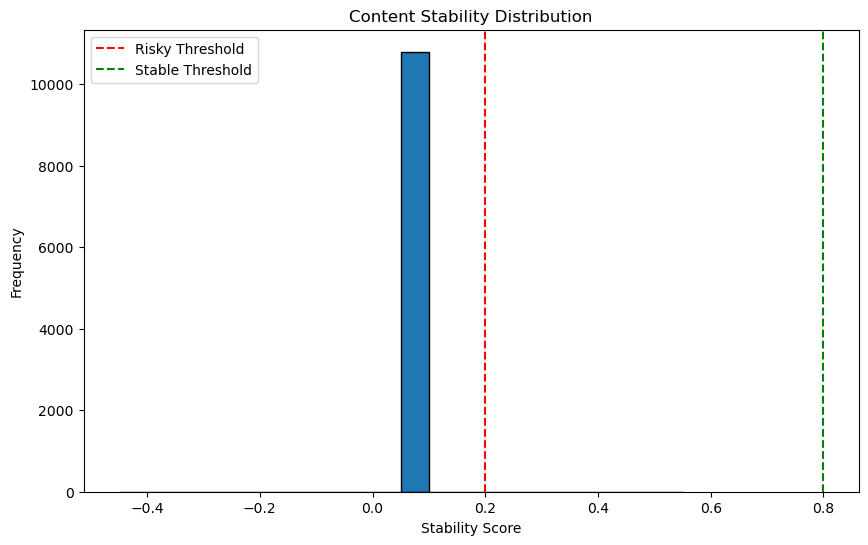

In [74]:
# Top Recommendations (Final List)
final_recommendations = context_scores.nlargest(10).index
recommendation_details = data.loc[data['title'].isin(final_recommendations), ['title', 'genre', 'rating', 'votes']]

# Content Stability Insights (Simulated from Monte Carlo)
stable_content = data[data['stability_score'] > 0.8]
risky_content = data[data['stability_score'] < 0.2]

# Visualize stable vs. risky content
plt.figure(figsize=(10, 6))
plt.hist(data['stability_score'], bins=20, edgecolor='black')
plt.axvline(0.2, color='red', linestyle='--', label='Risky Threshold')
plt.axvline(0.8, color='green', linestyle='--', label='Stable Threshold')
plt.title("Content Stability Distribution")
plt.xlabel("Stability Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [76]:
# Recommendation 1: Content Retention Strategy
retention_candidates = stable_content.nlargest(10, 'impact')[['title', 'genre', 'rating', 'votes', 'impact']]

# Recommendation 2: Content Improvement Strategy
improvement_candidates = risky_content.nlargest(10, 'impact')[['title', 'genre', 'rating', 'votes', 'impact']]

# Recommendation 3: Marketing Opportunities
top_diverse_content = diverse_scores.nlargest(10).index
diverse_details = data.loc[data['title'].isin(top_diverse_content), ['title', 'genre', 'rating', 'votes']]
print("Recommendation: Highlight the following diverse content in marketing campaigns:")
print(diverse_details)

Recommendation: Highlight the following diverse content in marketing campaigns:
                                         title                   genre  \
1159                               Big Brother                 Reality   
1583               Car Masters: Rust To Riches                 Reality   
2817                                 Explained           Documentation   
3586                            Harry & Meghan           Documentation   
4110  Inside Bill'S Brain: Decoding Bill Gates           Documentation   
4285                                 Jeen-Yuhs    Documentation, Music   
6333                                Our Planet           Documentation   
6485                    Pepsi, Where'S My Jet?  Documentation, History   
6748                                 Queer Eye                 Reality   
8677             The Great British Baking Show       Reality, European   

      rating    votes  
1159     5.2  10811.0  
1583     8.0  11045.0  
2817     7.9   9538.0  
3586     

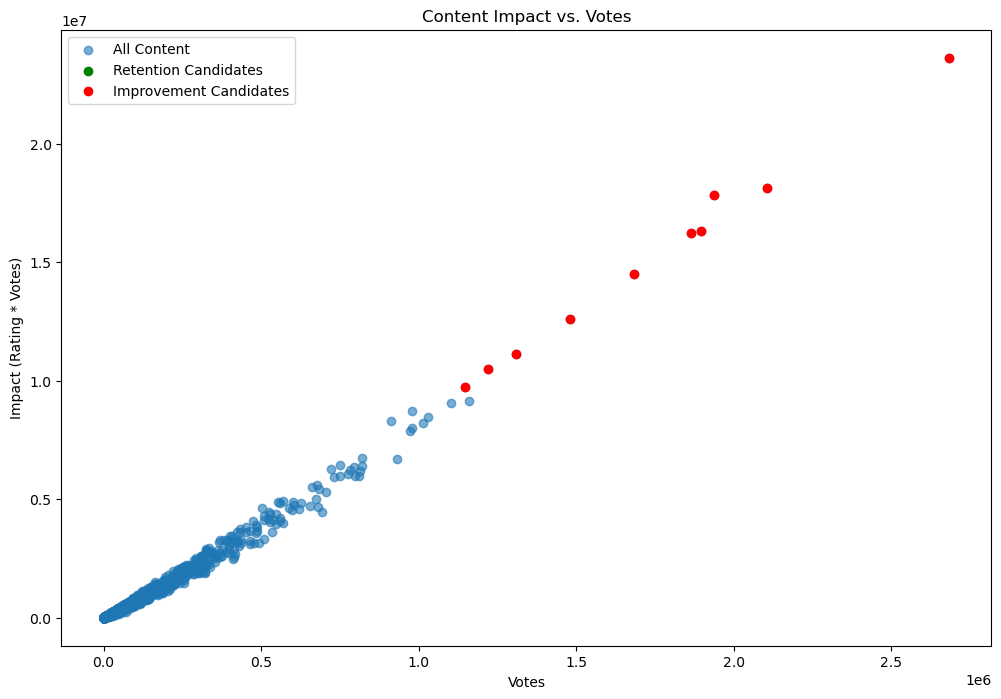

In [78]:
# Visualization of Content Recommendations (Impact vs. Votes)
plt.figure(figsize=(12, 8))
plt.scatter(data['votes'], data['impact'], alpha=0.6, label='All Content')
plt.scatter(retention_candidates['votes'], retention_candidates['impact'], color='green', label='Retention Candidates')
plt.scatter(improvement_candidates['votes'], improvement_candidates['impact'], color='red', label='Improvement Candidates')
plt.title("Content Impact vs. Votes")
plt.xlabel("Votes")
plt.ylabel("Impact (Rating * Votes)")
plt.legend()
plt.show()

In [80]:
# Consolidated Recommendations
actionable_recommendations = {
    "Content Retention": retention_candidates.to_dict('records'),
    "Content Improvement": improvement_candidates.to_dict('records'),
    "Marketing Highlights": diverse_details.to_dict('records')
}

# Display the actionable recommendations
print("\nFinal Actionable Recommendations for Stakeholders:")
for category, recommendations in actionable_recommendations.items():
    print(f"\n{category}:")
    for rec in recommendations:
        print(f"  - {rec['title']} (Genre: {rec['genre']}, Rating: {rec['rating']}, Votes: {rec['votes']})")


Final Actionable Recommendations for Stakeholders:

Content Retention:

Content Improvement:
  - The Dark Knight (Genre: Drama, Thriller, Action, Crime, Rating: 8.8, Votes: 2684317.0)
  - Forrest Gump (Genre: Comedy, Drama, Romance, Rating: 8.6, Votes: 2106826.0)
  - Breaking Bad (Genre: Drama, Comedy, Crime, Thriller, Rating: 9.2, Votes: 1936461.0)
  - The Lord Of The Rings: The Fellowship Of The Ring (Genre: Fantasy, Action, Drama, Rating: 8.6, Votes: 1895545.0)
  - The Lord Of The Rings: The Return Of The King (Genre: Fantasy, Action, Drama, Rating: 8.7, Votes: 1865989.0)
  - The Lord Of The Rings: The Two Towers (Genre: Action, Fantasy, Drama, Rating: 8.6, Votes: 1684864.0)
  - Gladiator (Genre: Action, Adventure, Drama, Rating: 8.5, Votes: 1481531.0)
  - The Departed (Genre: Crime, Drama, Thriller, Rating: 8.5, Votes: 1310171.0)
  - Stranger Things (Genre: Drama, Scifi, Thriller, Fantasy, Horror, Rating: 8.6, Votes: 1220079.0)
  - Léon: The Professional (Genre: Action, Crime, Dra

## Facilitate Visualization

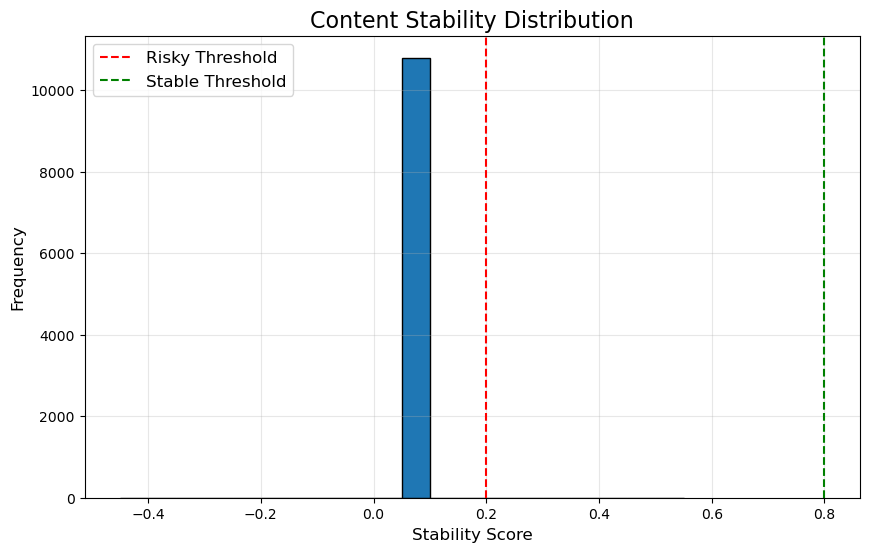

In [83]:
# Stability of content
plt.figure(figsize=(10, 6))
plt.hist(data['stability_score'], bins=20, edgecolor='black')
plt.axvline(0.2, color='red', linestyle='--', label='Risky Threshold')
plt.axvline(0.8, color='green', linestyle='--', label='Stable Threshold')
plt.title("Content Stability Distribution", fontsize=16)
plt.xlabel("Stability Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

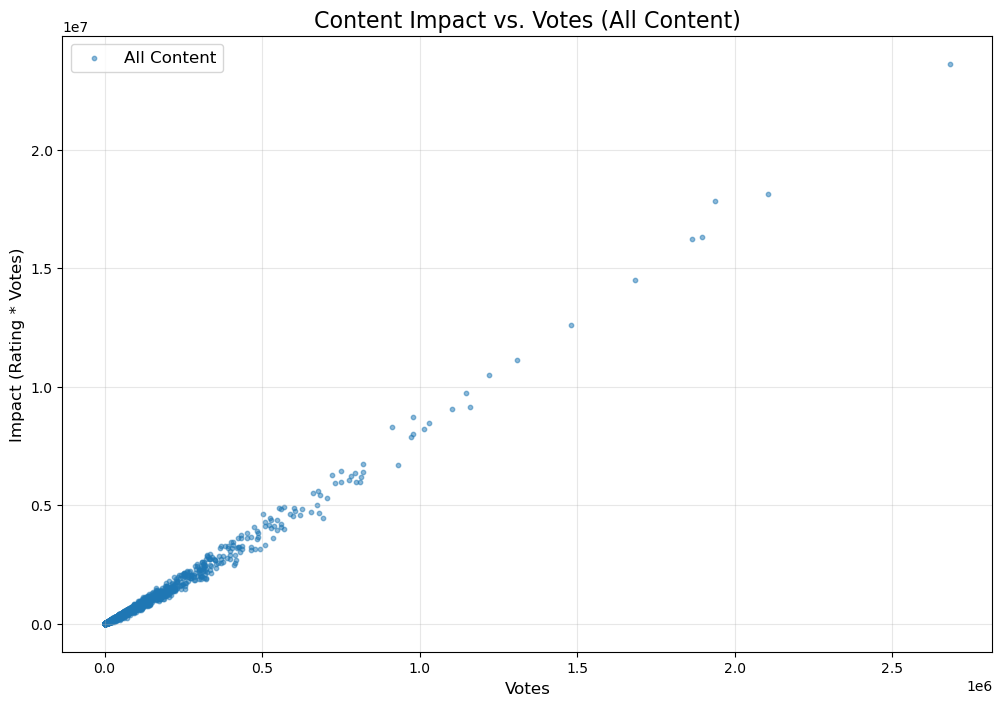

In [85]:
# Impact vs. Votes (All Content)
plt.figure(figsize=(12, 8))
plt.scatter(data['votes'], data['impact'], alpha=0.5, label='All Content', s=10)
plt.title("Content Impact vs. Votes (All Content)", fontsize=16)
plt.xlabel("Votes", fontsize=12)
plt.ylabel("Impact (Rating * Votes)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

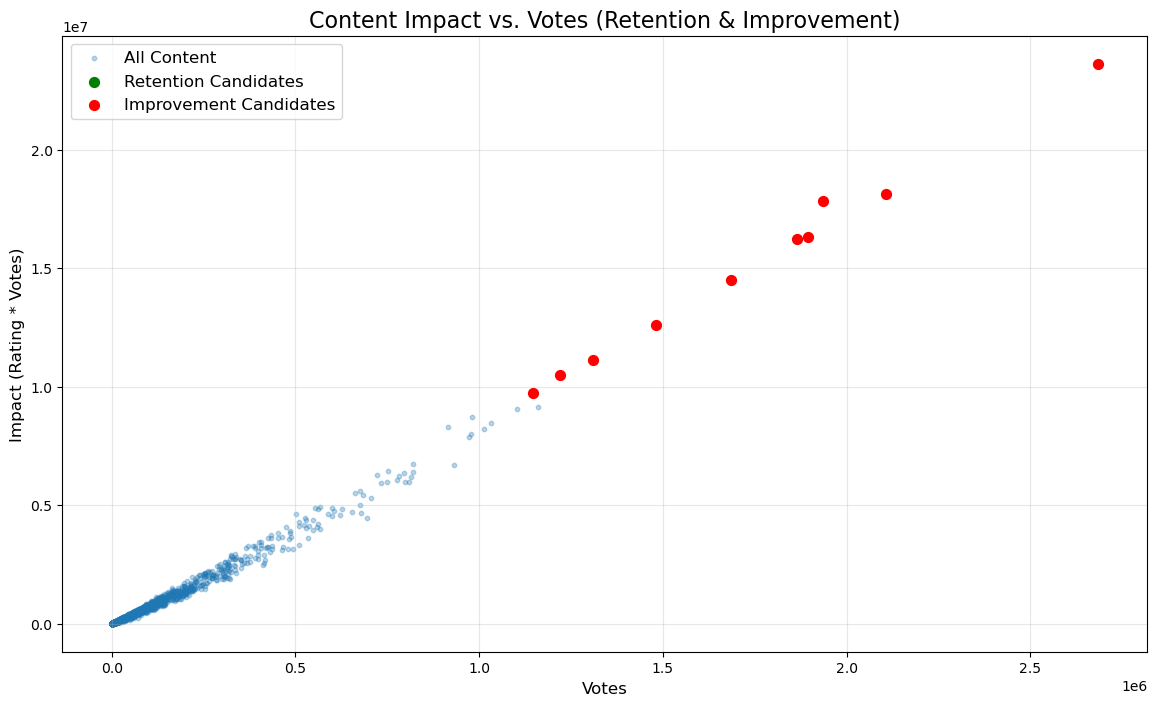

In [87]:
# Retention and Improvement of Content (Impact vs. Votes)
plt.figure(figsize=(14, 8))
plt.scatter(data['votes'], data['impact'], alpha=0.3, label='All Content', s=10)
plt.scatter(retention_candidates['votes'], retention_candidates['impact'], color='green', label='Retention Candidates', s=50)
plt.scatter(improvement_candidates['votes'], improvement_candidates['impact'], color='red', label='Improvement Candidates', s=50)
plt.title("Content Impact vs. Votes (Retention & Improvement)", fontsize=16)
plt.xlabel("Votes", fontsize=12)
plt.ylabel("Impact (Rating * Votes)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

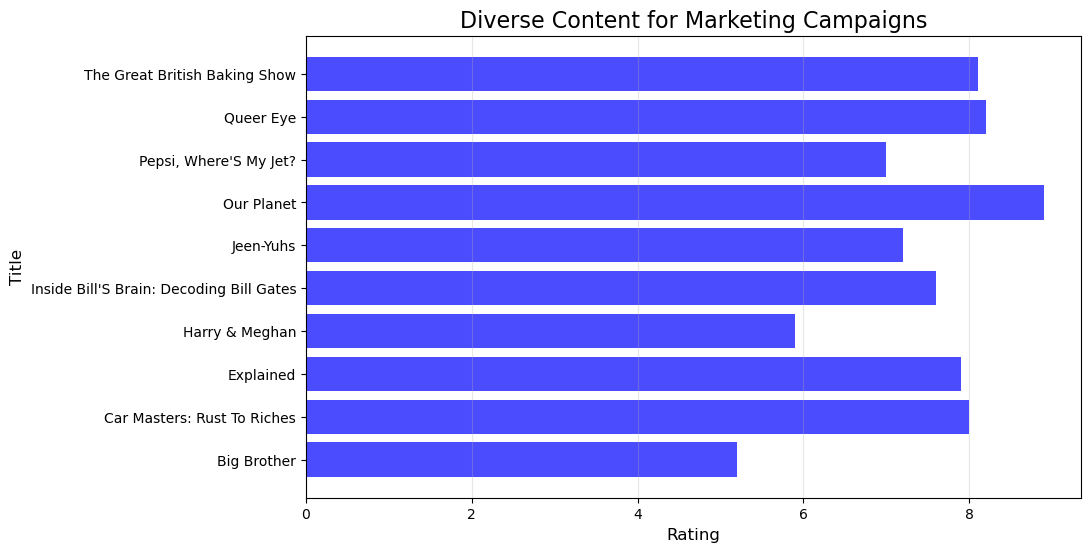

In [89]:
# Diverse Content for Marketing Campaigns
plt.figure(figsize=(10, 6))
plt.barh(diverse_details['title'], diverse_details['rating'], color='blue', alpha=0.7)
plt.title("Diverse Content for Marketing Campaigns", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Title", fontsize=12)
plt.grid(alpha=0.3, axis='x')
plt.show()